#**ANALISIS DE SENTIMIENTOS EN INGLES USANDO ACLIMDB**

##Obteniendo corpus de aclimdb

In [0]:
# instalar librería para visualizar el progreso de ejecución una tarea en background
pip install pyprind  

In [0]:
import os            #  trabajar sobre el sistema operativo
import sys           #  manipular archivos (cortar, copiar, borrar, crear)
import tarfile       #  Manipular archivos comprimidos (comprimir, descomprimir)
import time          #  calcular tiempo (en este caso tiempo de descarga de archivo)
import pyprind
import pandas as pd

basepath = 'aclImdb'
source = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
target = 'aclImdb_v1.tar.gz'


###función para ver avance de proceso en *background*

In [0]:
def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = progress_size / (1024.**2 * duration)
    percent = count * block_size * 100. / total_size
    sys.stdout.write("\r%d%% | %d MB | %.2f MB/s | %d segundos transcurrido" %
                    (percent, progress_size / (1024.**2), speed, duration))
    sys.stdout.flush()


if not os.path.isdir('aclImdb') and not os.path.isfile('aclImdb_v1.tar.gz'):
    
    if (sys.version_info < (3, 0)):
        import urllib
        urllib.urlretrieve(source, target, reporthook)
    
    else:
        import urllib.request
        urllib.request.urlretrieve(source, target, reporthook)


NameError: ignored

### Extraemos todos los archivos del corpus 

In [0]:
if not os.path.isdir('aclImdb'):

    with tarfile.open(target, 'r:gz') as tar:
        tar.extractall()

###Funcion para convertir archivos txt en un dataframe

In [0]:
labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)

df = pd.DataFrame()

for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 
                      'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], 
                           ignore_index=True)
            pbar.update()

df.columns = ['review', 'sentiment']


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:21


###Guardando Dataframe en CSV

In [0]:
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df.to_csv('movie_data.csv', index=False, encoding='utf-8')

##Preprocesamiento del corpus 

###Conectarmen a google drive y cargar el CSV de criticas de cine

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import pandas as pd
df = pd.DataFrame()
df = pd.read_csv('/content/gdrive/My Drive/USTA-202001/USTA-202001_7°_DEEP_LEARNING/Datasets/movie_data.csv', encoding='utf-8')

###Vectorizando texto

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

new_text = ['probando un texto para pruebas de texto']
vector= CountVectorizer(stop_words=None)
vector.fit(new_text)

print(vector.vocabulary_)


{'probando': 2, 'un': 5, 'texto': 4, 'para': 1, 'pruebas': 3, 'de': 0}


In [0]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
docs = np.array([
        'The sun is shining',
        'The weather is sweet',
        'The sun is shining, the weather is sweet, and one and one is two'])
bag = count.fit_transform(docs)

print(count.vocabulary_)


{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}


In [0]:
print(bag.toarray())

[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


###Extracción de características 

####TfidfTransformer

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, 
                         norm='l2', 
                         smooth_idf=True)
np.set_printoptions(precision=2)

print(tfidf.fit_transform(count.fit_transform(docs)).toarray())


[[0.   0.43 0.   0.56 0.56 0.   0.43 0.   0.  ]
 [0.   0.43 0.   0.   0.   0.56 0.43 0.   0.56]
 [0.5  0.45 0.5  0.19 0.19 0.19 0.3  0.25 0.19]]


In [0]:
df.head(7)

####funcion para limpiar textos de emoticones

In [0]:
import re

# creamos una funcion llamada preprocessor
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
    text = (re.sub('[\W]+', ' ', text.lower()) +' '.join(emoticons).replace('-', ''))
    return text

In [0]:
df['review'] = df['review'].apply(preprocessor)

In [0]:
import nltk
#nltk.download(“all")
#nltk.download("popular")
nltk.download("stopwords")

In [0]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [0]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

[w for w in tokenizer_porter('a runner likes running and runs a lot is very important')
if w not in stop]

['runner', 'like', 'run', 'run', 'lot', 'veri', 'import']

##Entrenando modelo usando REGRESIÓN LOGISTICA

In [0]:
from sklearn.pipeline import Pipeline                         # permite implementar métodos de ajuste y transformación
from sklearn.linear_model import LogisticRegression           # modelo de regresión logistica
from sklearn.feature_extraction.text import TfidfVectorizer   #conversor de texto a vector
from sklearn.model_selection import GridSearchCV              #búsqueda de cuadrícula con validación cruzada (para usar con regresión logistica)

In [0]:
# separamos los datos de entrenamiento y de pruebas
X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
#propiedades de la conversor de texto a vectores
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)
def tokenizer(text):
    return text.split()



In [0]:
#creación de dos diccionarios (1° para cálculos de TF-IDF, 2° para entrenar modelo con regresión logistica
param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]}, ]


In [0]:
#mezclamos regresión lineal y vectores de textos en un solo proceso
lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])


In [0]:
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)


In [0]:
gs_lr_tfidf.fit(X_train, y_train)



---


#**ANALISIS DE SENTIMIENTOS EN ESPAÑOL USANDO TWITTER**

##Obtener Dataset de twitter para analizar
https://github.com/jcsobrino/TFM-Analisis_sentimientos_Twitter-UOC

###cargar librerias

In [0]:
import os
import tweepy as tw
import pandas as pd

###permisos de acceso desde python a el api rest

In [0]:
consumer_key= 'nkjbpKyMEGEO8Ezy84figKZ0v'
consumer_secret= 'eFdTEbucPvRNtXH74L98SjIg51Olc4LGcuTwL5hdhPBUfiu0Vq'
access_token= '1176236145551826951-CyxNooeUEUscCt8j5Z5LOlDTtUzUJv'
access_token_secret= 'mhsQ6rwRlXXtYGUhNgxfyh9P7PN6MwXxaGQEk4qOWJmAI'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

###Subiendo un tweet

In [0]:
api.update_status('#USTATUNJA, subiendo mi primer tweet desde PYTHON 20200327 2.26pm')

###Consultando tweets 

In [0]:
# Definir el termino de la busqueda y la fecha de inicio
search_words = '#COVID19'
date_since = '2020-03-27'
#para que no tome los tweets que estar retweets
new_search = search_words + " -filter:retweets"
new_search
# Collecional tweets
tweets = tw.Cursor(api.search,
              q=new_search,
              lang="es",
              since=date_since).items(1000)
tweets

###Convertimos los tweets en una Dataframe


In [0]:
data_frame = [[tweet.user.screen_name, tweet.user.location,tweet.text] for tweet in tweets]

tw_dataframe = pd.DataFrame(data= data_frame , columns=["user","location","text"])
tw_dataframe
#guardamos el dataframe en un CSV
tw_dataframe.to_csv('twitter_ClimateChange_data.csv', index=False, encoding='utf-8')



---



---



##P0. Obtener corpus : Convirtiendo XML a CSV

In [0]:
#librerias necesarias
import xml.etree.ElementTree as etree
import csv
from os import scandir
from sklearn.model_selection import train_test_split

###Funcion para listar archivos de un directorio

In [0]:
# importing os module  
import os 
#listado_de_archivos_desde_un_path
def files_of_path(path): 
    return [obj.name for obj in os.scandir(path) if obj.is_file()]
    
files= files_of_path("/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/tass_2017/")
for file in files:
    print(file)

###función para convertir listas en archivos CSV

In [0]:
def list_to_csv(data, filename):
  with open(filename, 'w', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', lineterminator='\n', quoting=csv.QUOTE_NONNUMERIC)
    writer.writerows(data)

###función para cargar de un CSV a  una LISTA (messages | labels)

In [0]:
def csv_to_lists(filename):
  messages = []
  labels = []
  with open(filename, 'r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      messages.append(row[1])
      labels.append(row[2])
  return messages, labels

###funciones para prasear xml en un dataframe

####corpus de general  tweetid | content | sentiments/polarity/value

In [0]:
def general_tass_to_list(filename):
  tree = etree.parse(filename)
  root = tree.getroot()
  data = []

  for tweet in root:
    tweetId = tweet.find('tweetid').text
    content = tweet.find('content').text
    polarityValue = tweet.find('sentiments/polarity/value').text
    data.append([tweetId, content.replace('\n',' '), polarityValue])
  return data

In [0]:
def general_tass_2017_to_list(filename,qrel=None):
  tree = etree.parse(filename)
  root = tree.getroot()
  data = []

  for tweet in root:
    tweetId = tweet.find('tweetid').text
    content = tweet.find('content').text
    polarityValue = qrel[tweetId]
    data.append([tweetId, content.replace('\n',' '), polarityValue])

  return data

####Corpus politics  tweetid | content | sentiments/polarity

In [0]:
def politics_tass_to_list(filename):
  tree = etree.parse(filename)
  root = tree.getroot()
  data = []

  for tweet in root:
    tweetId = tweet.find('tweetid').text
    content = tweet.find('content').text
    aux = next((e for e in tweet.findall('sentiments/polarity') if e.find('entity') == None), None)
    if aux != None:
      polarityValue = aux.find('value').text
      data.append([tweetId, content.replace('\n',' '), polarityValue])
  return data

####corpus de internacional  tweetid | content | sentiments/polarity/value

In [0]:
def intertass_tass_to_list(filename, qrel=None):
  tree = etree.parse(filename)
  root = tree.getroot()
  data = []

  for tweet in root:
    tweetId = tweet.find('tweetid').text
    content = tweet.find('content').text
    polarityValue = tweet.find('sentiment/polarity/value').text
    if polarityValue == None:
      polarityValue = qrel[tweetId]
      data.append([tweetId, content.replace('\n',' '), polarityValue])
  return data

####Parcear corpus de social-TV (no esta terminado)

In [0]:
from lxml import etree
doc = etree.parse('/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/tass_2017/Social-TV/socialtv-tweets-test.xml')
#print (etree.tostring(doc,pretty_print=True ,xml_declaration=True, encoding="utf-8"))


tweets


In [0]:
raiz=doc.getroot()
#print (raiz.tag)
#print (len(raiz))
tweet=raiz[1]
print (tweet.text)
print (tweet.attrib)
print (tweet[0].text)
for attr,value in tweet.items():
  print (attr,value)
print (tweet.get("sentiment"))

El 
{'id': '456544890499760129'}
Barça
id 456544890499760129
None


In [0]:
from xml.dom import minidom
def social_tv_to_list(filename):
  xmldoc = minidom.parse(filename)
  tweetlist = xmldoc.getElementsByTagName('tweet')
  print(len(tweetlist))
  print(tweetlist[0].attributes['id'].value)
  sentimentlist = xmldoc.getElementsByTagName('sentiment')
  print(sentimentlist[0].attributes['aspect'].value)
  #for s in tweetlist:
#    print(s.attributes['id'].value)


In [0]:
social_tv_to_list("/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/tass_2017/Social-TV/socialtv-tweets-test.xml")

1000
456544890097131521
Entrenador


####funcion para unir los tweets corpus general test con sus sentimientos



In [0]:
#Listar los id tweets | sentiment :P (Positivo) - N (Negativo) - NEU (NEUtro) - NONE (sin sentimiento)
def gold_standard_to_dict(filename):
  with open(filename, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    data = {rows[0]: rows[1] for rows in reader}

  return data

###Función para separar el 100% del corpus entre: Train : 70% - Test: 30%


In [0]:
def generate_train_test_subsets(data, size):
  codes = [d[0] for d in data]
  labels = [d[2] for d in data]
  codes_train, codes_test, labels_train, labels_test = train_test_split(codes, labels, train_size=size)
  train_data = [d for d in data if d[0] in codes_train]
  test_data = [d for d in data if d[0] in codes_test]
  return train_data, test_data

### **Ejecutar cada función de parsear los corpus y guardarlo en un CSV (full, train, test)**

In [0]:
data = []

#Parceamos el internacional TASS
#tomamos el corpus internacional (test) y generamos una lista del ID del tweet y el sentimiento para agregarlo a la data
qrel = gold_standard_to_dict("/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/tass/intertass-sentiment.qrel")
#como el test del corpus internacional esta sin los sentimientos es necesario agregarlos : qrel
data.extend(intertass_tass_to_list("/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/tass/intertass-test.xml", qrel))
data.extend(intertass_tass_to_list("/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/tass_2017/InterTASS/InterTASS_development.xml"))
data.extend(intertass_tass_to_list("/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/tass_2017/InterTASS/InterTASS_Training.xml"))
#Parceamos el General
#data.extend(DatasetHelper.general_tass_to_list("../datasets/tass_2017/InterTASS/general-test-tagged-3l.xml"))
#data.extend(DatasetHelper.general_tass_to_list("../datasets/tass_2017/InterTASS/general-train-tagged-3l.xml"))
qrel = gold_standard_to_dict("/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/tass_2017/General Corpus of TASS/general-sentiment-3l.qrel")
data.extend(general_tass_2017_to_list("/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/tass_2017/General Corpus of TASS/general-tweets-test.xml", qrel))
#Parceamos el STOMPOL (politica)
data.extend(politics_tass_to_list("/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/tass/politics-test-tagged.xml"))
#separamos la data en train = 70%  | test = 30#
test, train  = generate_train_test_subsets(data, size=0.3)
list_to_csv(data,"/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/dataset_2017_full.csv")
list_to_csv(train, '/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/dataset_2017_train.csv')
list_to_csv(test, '/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/dataset_2017_test.csv')


##P1. Preprocesamiento del corpus

###Cargar librerías necesarias

In [0]:
import re                                #operaciones regulares para la búsqueda y manipulación de cadenas
from nltk import TweetTokenizer          #libreria para tokenizar
from nltk.stem import SnowballStemmer    #algoritmo para clasificación de palabras
#variables para mejorar la escritura (opcional)
NORMALIZE = 'normalize'
REMOVE = 'remove'
MENTION = 'twmention'
HASHTAG = 'twhashtag'
URL = 'twurl'
LAUGH = 'twlaugh'

#definir que el algoritmo de clasificación use el idioma español
_stemmer = SnowballStemmer('spanish')

#definir una variable para la funcion de tokenizar (opcional)
_tokenizer = TweetTokenizer().tokenize

#variable para definir si quiero normalizar: normalize o eliminar: remove los hashtags, menciones y urls en los tweets
_twitter_features="normalize"
#variable para definir si se desea tener convertir o no a la raiz de la palabra.
_stemming=False

### funciones/métodos de preprocesamiento

####listas de conversión (quitar tildes y palabras coloquiales) 

In [0]:
#lista de conversión para quitar las tildes a las vocales.
DIACRITICAL_VOWELS = [('á','a'), ('é','e'), ('í','i'), ('ó','o'), ('ú','u'), ('ü','u')]

#lista para corregir algunas palabras coloquiales / jerga en español (obviamente faltan más)
SLANG = [('d','de'), ('[qk]','que'), ('xo','pero'), ('xa', 'para'), ('[xp]q','porque'),('es[qk]', 'es que'),
         ('fvr','favor'),('(xfa|xf|pf|plis|pls|porfa)', 'por favor'), ('dnd','donde'), ('tb', 'también'),
         ('(tq|tk)', 'te quiero'), ('(tqm|tkm)', 'te quiero mucho'), ('x','por'), ('\+','mas')]

#### funcion/método de normalización de risas

In [0]:
#metodo para normalizar las risas
def normalize_laughs(message):
  message = re.sub(r'\b(?=\w*[j])[aeiouj]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
  message = re.sub(r'\b(?=\w*[k])[aeiouk]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
  message = re.sub(r'\b(juas+|lol)\b', LAUGH, message, flags=re.IGNORECASE)
  return message

In [0]:
print (normalize_laughs("esto muyy feliz jajajajaja o no tan feliz jejejejeje o mejor me rio a como papa noel JOJOJO o como en mileniams LOL  kakaka"))

esto muyy feliz twlaugh o no tan feliz twlaugh o mejor me rio a como papa noel twlaugh o como en mileniams twlaugh  twlaugh


####Función/método para eliminar o normalizar  menciones, hashtags y URL de un mensaje (tweet)

In [0]:
def process_twitter_features(message, twitter_features):

  message = re.sub(r'[\.\,]http','. http', message, flags=re.IGNORECASE)
  message = re.sub(r'[\.\,]#', '. #', message)
  message = re.sub(r'[\.\,]@', '. @', message)

  if twitter_features == REMOVE:
    # eliminar menciones, hashtags y URL
    message = re.sub(r'((?<=\s)|(?<=\A))(@|#)\S+', '', message)
    message = re.sub(r'\b(https?:\S+)\b', '', message, flags=re.IGNORECASE)
  elif twitter_features == NORMALIZE:
    # cuando sea necesario se normalizaran las menciones, hashtags y URL
    message = re.sub(r'((?<=\s)|(?<=\A))@\S+', MENTION, message)
    message = re.sub(r'((?<=\s)|(?<=\A))#\S+', HASHTAG, message)
    message = re.sub(r'\b(https?:\S+)\b', URL, message, flags=re.IGNORECASE)

  return message

In [0]:
print(process_twitter_features("Rosell, una noche. Adivina quien!! http://t.co/PPAwijRX","normalize"))

Rosell, una noche. Adivina quien!! twurl


####Función/método general para el preprocesamiento

In [0]:
def preprocess(message):
  # convertir a minusculas
  message = message.lower()
        
  # eliminar números, retorno de linea y el tan odios retweet (de los viejos estilos de twitter)
  message = re.sub(r'(\d+|\n|\brt\b)', '', message)
        
  # elimar vocales con signos diacríticos (posible ambigüedad)
  for s,t in DIACRITICAL_VOWELS:
    message = re.sub(r'{0}'.format(s), t, message)
        
  # eliminar caracteres repetidos 
  message = re.sub(r'(.)\1{2,}', r'\1\1', message)
       
  # normalizar las risas
  message = normalize_laughs(message)
        
  # traducir la jerga y terminos coloquiales sobre todo en el español
  for s,t in SLANG:
    message = re.sub(r'\b{0}\b'.format(s), t, message)

  #normalizar/eliminar hashtags, menciones y URL
  message = process_twitter_features(message, _twitter_features)

  #Convertir las palabras a su raiz ( Bonita, bonito) -> bonit 
  if _stemming:
    message = ' '.join(_stemmer.stem(w) for w in _tokenizer(message))

  return message

In [0]:
print(preprocess("LOL!! muy graciosa esta paguina https://actualidadpanamericana.com :-) jajajaja muy buena"))

twlaugh!! muy graciosa esta paguina twurl :-) twlaugh muy buena


###Descargamos la librerias  NLTK

In [0]:
#Descargamos la libreria de stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Cargamos el CSV del corpus de google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


###Aplicamos preprocesamiento al CSV y creamos un nuevo CSV limpio

In [0]:
import numpy as np
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/dataset_2017_full.csv', encoding='utf-8')
#asignamos nombres a las columnas del csv para facilitar la busqueda de información
df.columns = ['tweetid', 'tweet','sentiment']
#aplicamos el preprocesamiento a los tweets con steaming =false
df['tweet'] = df['tweet'].apply(preprocess)
#eliminamos la columna tweetid que no nos sirve para entrenar y si nos genera mas uso de memoria 
df = df.drop(columns="tweetid")
#Es mejor trabajar con valores enteros que con letras
#por lo tanto reemplazaremos los sentimientos que estan como NONE->-1 | NEU -> 0 | P->1 | N->2
df.loc[df['sentiment'] == 'NONE', 'sentiment'] = '-1'
df.loc[df['sentiment'] == 'NEU', 'sentiment'] = '0'
df.loc[df['sentiment'] == 'P', 'sentiment'] = '1'
df.loc[df['sentiment'] == 'N', 'sentiment'] = '2'
df["sentiment"].unique()
#guardamos el dataset en un nuvevo CSV para facilitar su posterior uso
df.to_csv('/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/dataset_2017_full_clean.csv', index=False, encoding='utf-8')

##P2.Entrenando el modelo de aprendizaje

###Funciones de tokenizar/extraer tweets 

In [0]:
#p2.1: funcion tokenizar con esteroides --tokeniza y limpia--
print("p2.1: funcion tokenizar con esteroides --tokeniza y limpia--")
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized
#p2.2: funcion para extraer un documento del dataset  
print("p2.2: funcion para extraer un documento del dataset  ")
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv)  # skip header
        for line in csv:
            text, label = line[:-3],  int(line[-2])
            yield text, label
#p2.3: funcion que tomara una secuencia de documentos y devolvera un número particular de documentos
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

p1.1: funcion tokenizar con esteroides --tokeniza y limpia--
p1.2: funcion para extraer un documento del dataset  


In [0]:
next(stream_docs(path='/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/dataset_2017_full_clean.csv'))

('twmention ya era hora de volver al csgo y dejares el padel bienvenida ', 1)

###Entrenamos el modelo usando regresión logistica
usaremos regresión logistica xq es menos costoso en tiempo de procesamiento que support vector machine

In [0]:
path='/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/dataset_2017_full_clean.csv'
#p2: definimos una versión liviana de CountVectorizer+TfidfVectorizer llamada HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

#definimos como algoritmo la regressión logistica en el decenso gradiante 

clf = SGDClassifier(loss='log', random_state=1, max_iter=1)
doc_stream = stream_docs(path)
#p3. entrenamos 
import re
import numpy as np
import pyprind
from nltk.corpus import stopwords
stop = stopwords.words('spanish')
pbar = pyprind.ProgBar(50)
#definimos las clases con las cuales vamos a entrenar
classes = np.array([-1,0, 1,2])
#hacemos 50 repeticiones
for _ in range(50):
  #tomaremos grupos de 500 tweets para entrenar
    X_train, y_train = get_minibatch(doc_stream, size=500)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()
#probamos la eficiencia del modelo con 500 tweets .
X_test, y_test = get_minibatch(doc_stream, size=500)
X_test = vect.transform(X_test)
print('Presición del modelo: %.3f' % clf.score(X_test, y_test))
#recalibramos el modelo.
clf = clf.partial_fit(X_test, y_test)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Presición del modelo: 0.844


##P3.Serializamos (congelamos) el modelo para usarlo fuera de google colaboratory

In [0]:
import pickle
import os
#creo una carpeta en mi google drive para guardar los archivos serializados
dest = os.path.join('/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/twitterclassifier', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)
#convertimos el clasificador y el stopword en archivo/objectos pkl
pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)   
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)
#Es importante recordar que deben verificar que los dos archivos esten en su drive

###Probemos a ver si funciona
Cambiamos la basepath (directorio por defecto) de Python a la carpeta de **Twitterclassifier**

In [0]:
import os
os.chdir('/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/twitterclassifier')

####Deserializamos los estimadores 

In [0]:
import pickle
import re
import os
from vectorizer import vect
clf = pickle.load(open(os.path.join('pkl_objects', 'classifier.pkl'), 'rb'))

#### Clasifiquemos un texto

In [0]:
import numpy as np
#NONE->-1 | NEU -> 0 | P->1 | N->2
label = {-1:'Sin sentimiento', 0:'Neutro', 1:'Positivo',2: 'Negativo'}

#example = ['Te odio más que a la muerte']
example1 = 'covid19 te ODIOOOO'
example = [example1]
#convertimos el texto en un vector de palabras y extraemos sus caracteristicas https://scikit-learn.org/stable/modules/feature_extraction.html
textConvert = vect.transform(example)  
print('*Predicción: %s\n*Probabilidad: %.2f%%'%(label[clf.predict(textConvert)[0]], np.max(clf.predict_proba(textConvert))*100))
print('*Predicción: %s'%label[clf.predict(textConvert)[0]])
print(np.max(clf.predict_proba(textConvert))*100)


*Predicción: Positivo
*Probabilidad: 63.94%
*Predicción: Positivo
63.944211933486194


###**RECORREMOS LOS TWEETS DESCARGADOS Y LOS CLASIFICAMOS**

In [0]:
import numpy as np
import pandas as pd
import pyprind

df = pd.read_csv('/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/TWEETS_LGGG_COVID19.csv', encoding='utf-8')
#creamos una columna llamada Sentimient donde guardaremos la predicción
df['sentiment'] =''
#creamos una columna llamada Probability donde guardaremos la acertabilidad que dio el clasificador
df['probability']=0
#conversión de sentimientos (numeros a palabras)= NONE->-1 | NEU -> 0 | P->1 | N->2
label = {-1:'Sin sentimiento', 0:'Neutro', 1:'Positivo',2: 'Negativo'}
for rowid in range(len(df.index)):
  text=df['text'][rowid]
  textConvert = vect.transform([text]) 
  df['sentiment'][rowid]=label[clf.predict(textConvert)[0]]
  df['probability'][rowid]=np.max(clf.predict_proba(textConvert))*100
  pbar.update()
df.head(20)
#df.to_csv('/content/drive/My Drive/IA/Analisis_sentimientos_Twitter/datasets/TWEETS_LGGG_COVID19_analysis.csv', index=False, encoding='utf-8')

In [0]:
#segunda forma de ejecutar el analisis (metodos)
def f_prediction(row):
  text=row['text']
  textConvert = vect.transform([text]) 
  return label[clf.predict(textConvert)[0]]

def f_probability(row):
  text=row['text']
  textConvert = vect.transform([text]) 
  return np.max(clf.predict_proba(textConvert))*100

df["sentiment"] = df.apply(f_prediction, axis=1) # recorriendo columnas
df["probability"] = df.apply(f_probability, axis=1) # recorriendo columnas


sentiment
Negativo      2
Positivo    682
dtype: int64


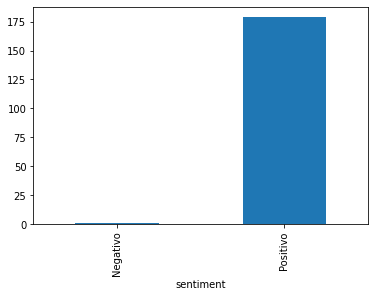

In [0]:
import matplotlib.pyplot as plt
#sentimientos = df["sentiment"].unique()
df.groupby('sentiment')['location'].nunique().plot(kind='bar')
print(df.groupby(['sentiment']).size())
#df.groupby(['sentiment']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

#df.head(20)
#df["sentiment"].unique()